### Author: Piotr Skoroszewski

Data set: imdb records

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_csv('data.csv')
data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


## Variable identification

|       variable name       | variable type |     data type     | variable category |         remarks         |
|:-------------------------:|:-------------:|:-----------------:|:-----------------:|:-----------------------:|
|                     color | predictor     | string            | categorical       | values: color, B&W, Nan |
|                  duration | predictor     | numeric, integer  | continious        |                         |
|    num_critic_for_reviews | predictor     | numeric, integer  | continious        |                         |
|             director_name | predictor     | string            | categorical       |                         |
|   director_facebook_likes | predictor     | numeric, integer  | continious        |                         |
|              actor_X_name | predictor     | string            | categorical       |                         |
|    actor_X_facebook_likes | predictor     | numeric, integer  | continous         |                         |
|                     gross | target        | numeric, integer  | continous         |                         |
|                    genres | predictor     | string            | categorical       | not atomic              |
|               movie_title | predictor     | string            | categorical       |                         |
|           num_voted_users | predictor     | numeric, integer  | continious        |                         |
| cast_total_facebook_likes | predictor     | numeric, integer  | continious        |                         |
|      facenumber_in_poster | predictor     | numeric, integer  | continious        |                         |
|             plot_keywords | predictor     | string            | categorical       | not atomic              |
|           movie_imdb_link | predictor     | string            | categorical       |                         |
|      num_user_for_reviews | predictor     | numeric, integer  | continious        |                         |
|                  language | predictor     | string            | categorical       |                         |
|                   country | predictor     | string            | categorical       |                         |
|            content_rating | predictor     | string            | categorical       |                         |
|                    budget | predictor     | numeric, integer  | continious        |                         |
|                title_year | predictor     | numeric, integer  | categorical       |                         |
|                imdb_score | predictor     | numeric, float    | continious        |                         |
|              aspect_ratio | predictor     | numeric, float    | continious        |                         |
|      movie_facebook_likes | target        | numeric, integer  | continious        |                         |

## Feature engineering:

In [3]:
import seaborn as sns

# correlation heat map routine
def show_corr_heatmap(names=None):
    data_corr = pd.DataFrame(data, columns=names) if names else data
    correlations = data_corr.corr()
    fig, ax = plt.subplots(figsize=(18,18))
    sns.heatmap(correlations,
                cmap="RdBu",
                xticklabels=correlations.columns,
                yticklabels=correlations.columns,
                ax=ax)

### color
Change the column type to numeric

In [4]:
color = data['color']
set(color)

{nan, ' Black and White', 'Color'}

In [5]:
data.loc[data.color == 'Color', 'color'] = 1
data.loc[data.color == ' Black and White', 'color'] = 0

### genres
Split genres to separate variable

In [6]:
genres_uniq = set()
for genres in data['genres']:
    genres_uniq.update(genres.split('|'))
print 'number of all genres:', len(genres_uniq)

number of all genres: 26


The number of different genre is small, so it is reasonable to change this column to atomic form. I will add 26 new bool variable

In [7]:
new_genres_headers = map(lambda x: 'genre_'+x.lower(), genres_uniq)
new_genres_names_map = zip(genres_uniq, new_genres_headers)
for genre, genre_header in new_genres_names_map:
    data.loc[[genre in g for g in data.genres], genre_header] = 1
    data.loc[[genre not in g for g in data.genres], genre_header] = 0

### Genres corellation

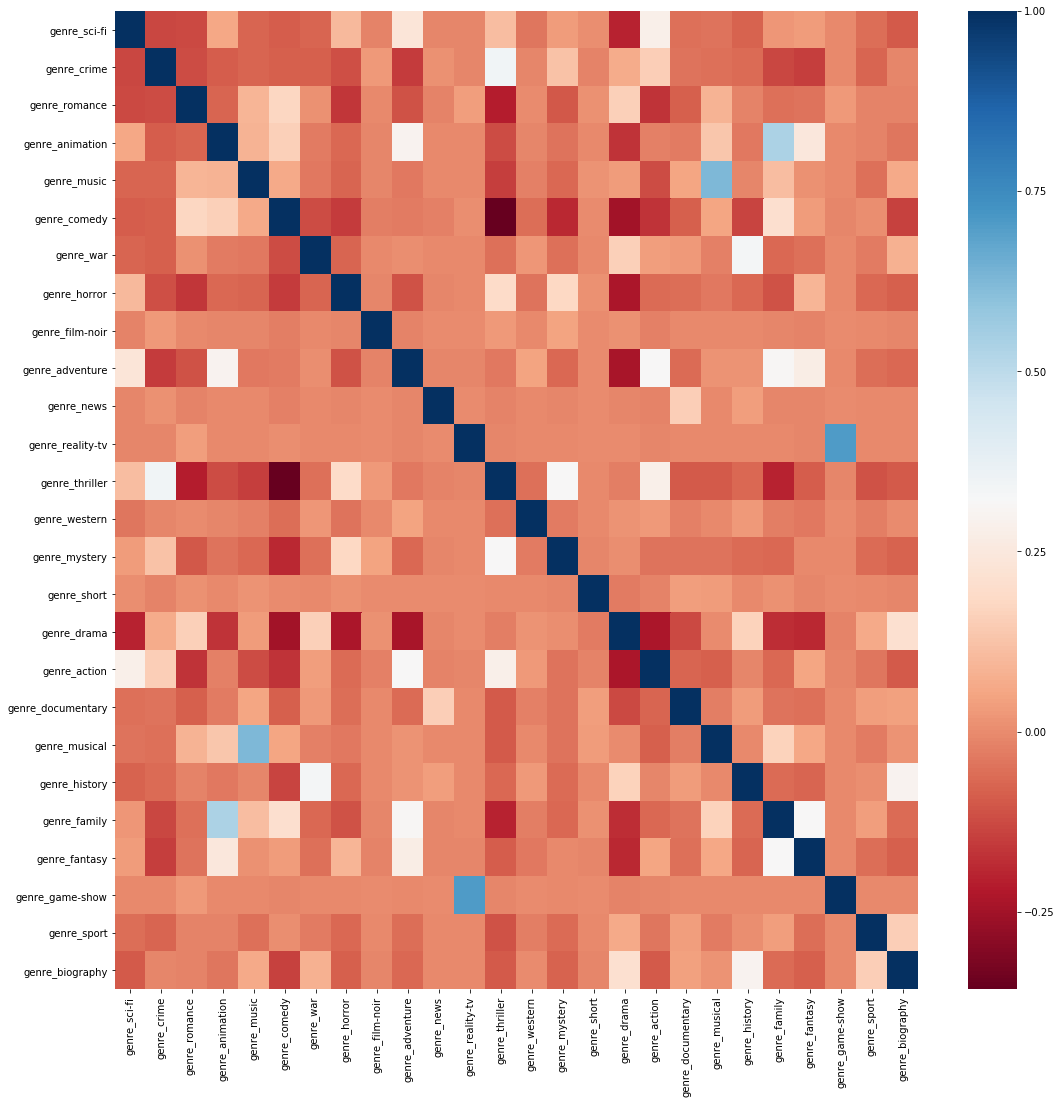

In [8]:
show_corr_heatmap(names=new_genres_headers)

We can notice the strong positive correlation between:
* genre_game-show, genre_reality-tv
* genre_family, genre_animation, genre_fantasy
* genre_musicl, genre_musical
and strong negative correlation between:
* genre_thriller, genre_comedy
* genre_drama and genre_sci-fi, genre_comendy, genre_horror, genre_adventure, genre_action, genre_family, genre_fantasy

Combine small subset of features

In [9]:
data['genre_game-show'] = data[['genre_game-show', 'genre_reality-tv']].max(axis=1)
data['genre_music'] = data[['genre_musical', 'genre_music']].max(axis=1)
data['genre_thriller'] = 1-data[['genre_comedy']]

In [10]:
drop_variables = ['genre_reality-tv', 'genre_musical', 'genre_comedy']
try:
    data.drop(labels=drop_variables,axis=1, inplace=True)
except:
    pass

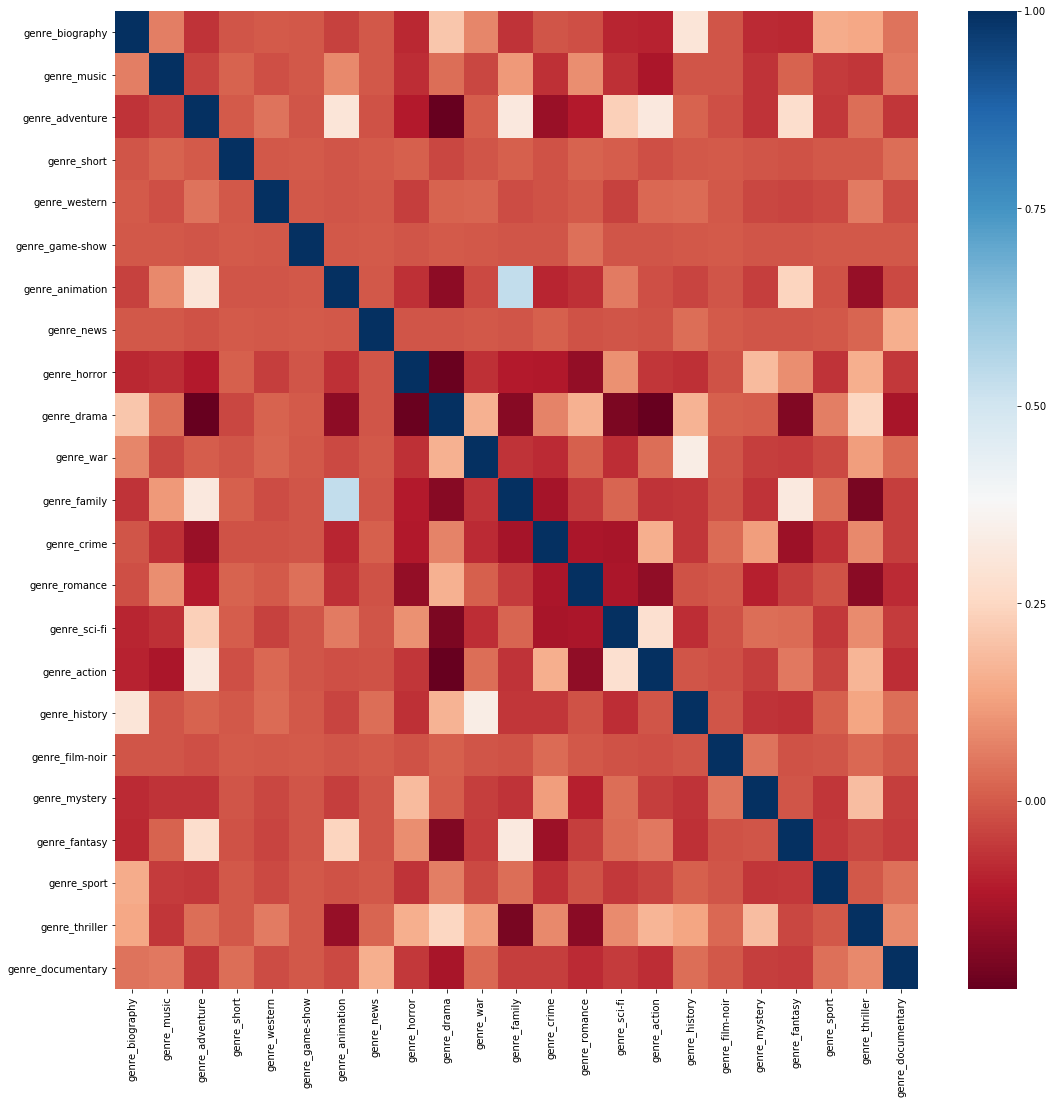

In [11]:
new_genres_headers = set(new_genres_headers) - set(drop_variables)
show_corr_heatmap(names=new_genres_headers)

### plot keywords

I would like to connect similar keywords together. To do this i split plot keywords into single words, remove punctuation and then apply Lancaster Stemmer on them. This reduce number of uniqe 'phrases'
(http://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization)

In [12]:
import string
from itertools import chain
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()

def process_plot_keywords(line):
    words = line.split('|')
    words = map(lambda w: w.translate(None, string.punctuation), words)  # remove punctuation
    words = list(chain(*map(lambda w: w.split(), words)))  # flat map of words
    words = map(lambda w: lancaster_stemmer.stem(w), words)  # stem words
    words = filter(lambda w: len(w) > 2, words)  # filter short words eg. many of 'as', 'of', 'a ', 'at'
    return set(words)  # remove possible duplication

data['plot_keywords_lem'] = data['plot_keywords'].fillna("").apply(process_plot_keywords)

Calculate top\{5, 50, 100, 200\} most frequent words

In [13]:
from collections import Counter
words_counter_map = map(Counter, data['plot_keywords_lem'])
words_counter = reduce(lambda a, b: a.update(b) or a, words_counter_map)  # Hack, Counter.update returns None; words_counter_map wasted

def get_most_common_words(k):
    word_freq = words_counter.most_common(k)
    return map(lambda (w, f): w, word_freq)

top5, top20, top50, top100 = map(get_most_common_words, [5, 20, 50, 100])

In [14]:
from itertools import imap

def count_top_words(words_set, top_k_words):
    return sum(imap(lambda top_w: 1 if top_w in words_set else 0, top_k_words))

data['plot_keywords_top5']   = data['plot_keywords_lem'].apply(lambda ws: count_top_words(ws, top5))
data['plot_keywords_top20']  = data['plot_keywords_lem'].apply(lambda ws: count_top_words(ws, top20))
data['plot_keywords_top50']  = data['plot_keywords_lem'].apply(lambda ws: count_top_words(ws, top50))
data['plot_keywords_top100'] = data['plot_keywords_lem'].apply(lambda ws: count_top_words(ws, top100))

In [15]:
def describe_pk_top(k, df):
    print 'TOP', k
    print 'sum\t', df.sum()
    print df.describe()
    df.plot.hist()

TOP 5
sum	1243
count    5043.000000
mean        0.246480
std         0.497241
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: plot_keywords_top5, dtype: float64


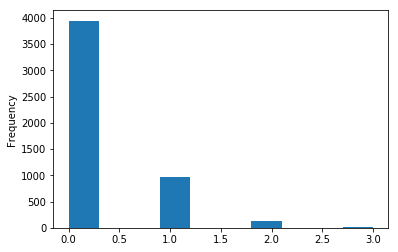

In [16]:
describe_pk_top(5, data['plot_keywords_top5'])

TOP 20
sum	3709
count    5043.000000
mean        0.735475
std         0.991547
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         7.000000
Name: plot_keywords_top20, dtype: float64


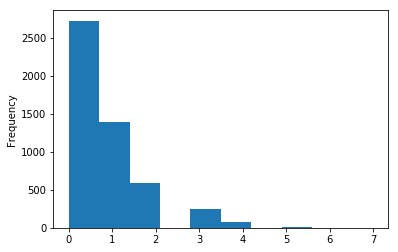

In [17]:
describe_pk_top(20, data['plot_keywords_top20'])

TOP 50
sum	6402
count    5043.000000
mean        1.269482
std         1.285409
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: plot_keywords_top50, dtype: float64


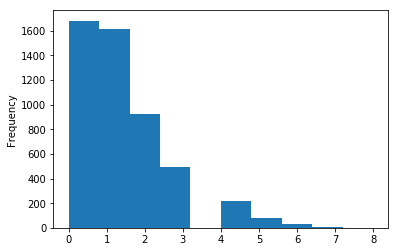

In [18]:
describe_pk_top(50, data['plot_keywords_top50'])

TOP 100
sum	9402
count    5043.000000
mean        1.864366
std         1.512163
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         9.000000
Name: plot_keywords_top100, dtype: float64


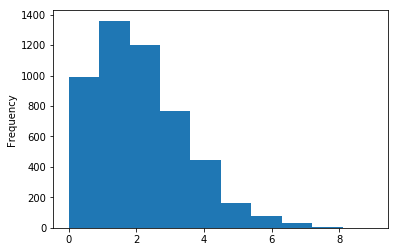

In [19]:
describe_pk_top(100, data['plot_keywords_top100'])

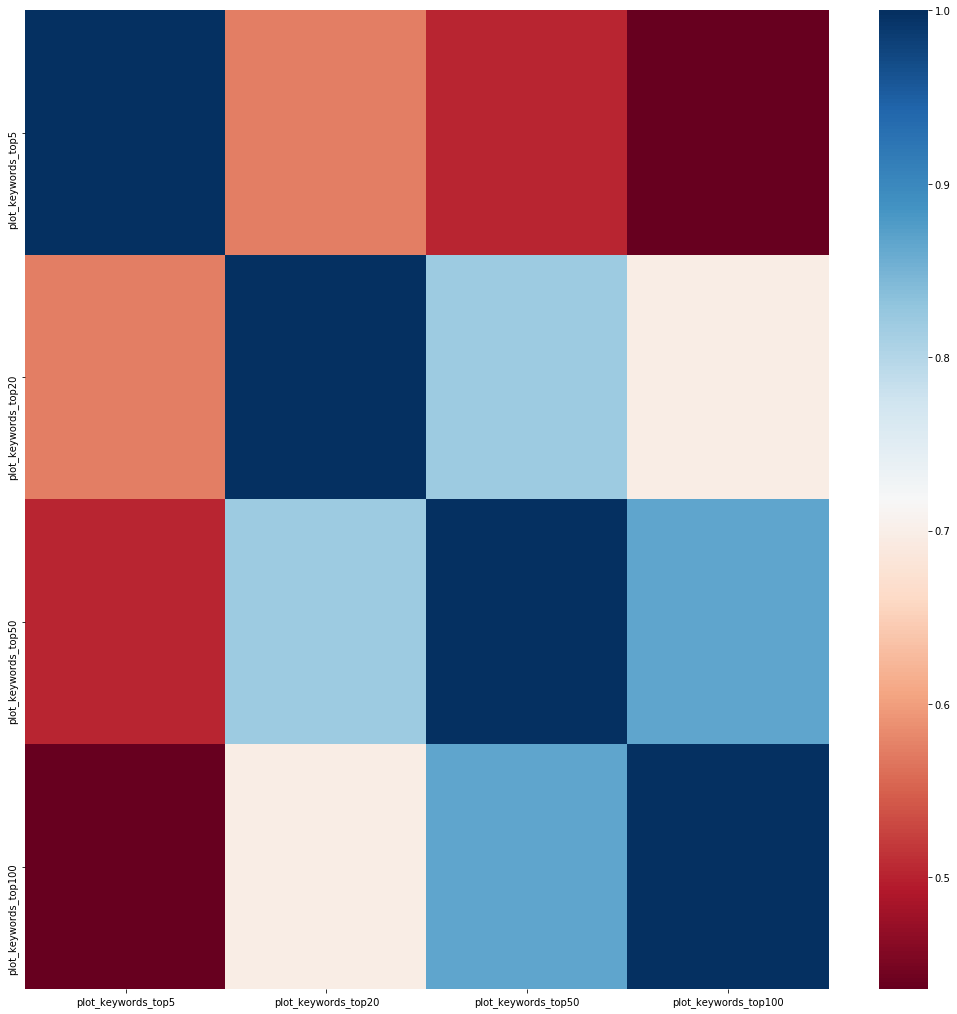

In [20]:
top_x_names = ['plot_keywords_top5', 'plot_keywords_top20', 'plot_keywords_top50', 'plot_keywords_top100']
show_corr_heatmap(names=top_x_names)

We can notice that the smallest correlation is between top20 and top100, so we drop top5 and top50

In [21]:
drop_variables = ['plot_keywords_top5', 'plot_keywords_top50']
try:
    data.drop(labels=drop_variables ,axis=1, inplace=True)
except:
    pass

### Director_name

The sum of movie likes depending of the director. As we can see 'Christopher Nolan' is an outlier.

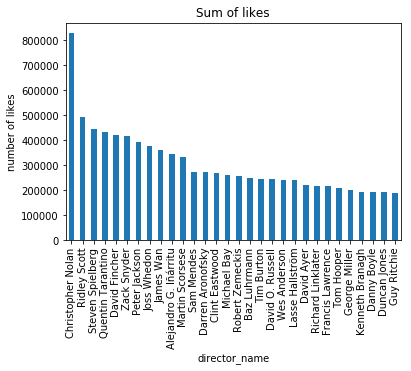

In [22]:
director_movie_sum_likes = data[['director_name', 'movie_facebook_likes']] \
    .groupby('director_name') \
    .sum() \
    .nlargest(30, 'movie_facebook_likes') \
    .plot(kind='bar', sort_columns=True, title='Sum of likes', legend=False) \
    .set_ylabel('number of likes')

The mean movie likes

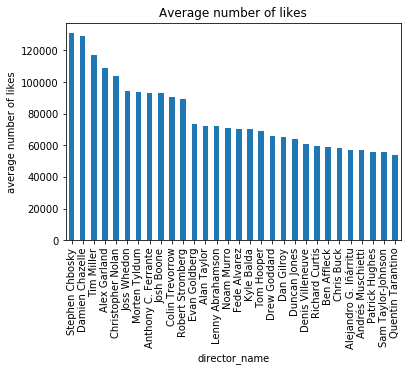

In [23]:
director_movie_mean_likes = data[['director_name', 'movie_facebook_likes']] \
    .groupby('director_name') \
    .mean() \
    .nlargest(30, 'movie_facebook_likes') \
    .plot(kind='bar', sort_columns=True, title='Average number of likes', legend=False) \
    .set_ylabel('average number of likes')

### Content rating

In [24]:
content_rating = set(data.content_rating)
print content_rating

set([nan, 'TV-Y', 'G', 'GP', 'TV-14', 'NC-17', 'M', 'PG-13', 'Approved', 'TV-Y7', 'R', 'Not Rated', 'PG', 'Passed', 'X', 'TV-MA', 'TV-PG', 'TV-G', 'Unrated'])


I have created new liniear variable that covers content_rating depending of the age:
* 0 - All ages admitted (Approved, G, GP, PG, Passed, TV-G, TV-PG, M, TV-Y)
* 1 - Not rated (Not Rated, Unrated). Also we treat NaN as unrated
* 2 - No one under low age (7-14) admitted (PG-13, TV-14, TV-Y7)
* 3 - No under ~17 admitted (NC-17, R, TV-MA, X)

In [25]:
cr_headers = [
    {'Approved', 'G', 'GP', 'PG', 'Passed', 'TV-G', 'TV-PG', 'M', 'TV-Y'},
    {'Not Rated', 'Unrated', np.nan},
    {'PG-13', 'TV-14', 'TV-Y7'},
    {'NC-17', 'R', 'TV-MA', 'X'},
]

for i, cr_h in enumerate(cr_headers):
    data.loc[[cr in cr_h for cr in data.content_rating], 'content_rating'] = i


### Outliers

In [26]:
def return_outliers_k_std(column, k):
    df = pd.DataFrame(data, columns=[column])
    df = df[np.abs(df[column]-df[column].mean())>(k*df[column].std())]
    return df

In [27]:
return_outliers_k_std('movie_facebook_likes', 3)

,movie_facebook_likes
2,85000
3,164000
8,118000
10,197000
15,118000
17,123000
23,83000
27,72000
29,150000
30,80000


#### aspect_ratio

The value 16.0 is inproper for aspect ratio. After checking some imda url, the aspect ratio (with high propability) should be 16/9

In [28]:
return_outliers_k_std('aspect_ratio', 3).head()

,aspect_ratio
459,16.0
537,16.0
593,16.0
645,16.0
833,16.0


In [29]:
data.loc[data.aspect_ratio == 16.0, 'aspect_ratio'] = 16.0/9
# second iteration
return_outliers_k_std('aspect_ratio', 3).head()

,aspect_ratio
260,4.00
479,4.00
1175,4.00
1972,4.00
2363,1.18


In [30]:
# We did the same for 4.0. The common aspect ratio should be 4:3
# only one movie in the history has aspect ratio 4.0
data.loc[data.aspect_ratio == 4.0, 'aspect_ratio'] = 4.0/3

#### imdb score

mean score imdb_score    6.442138
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef4fe85e50>]], dtype=object)

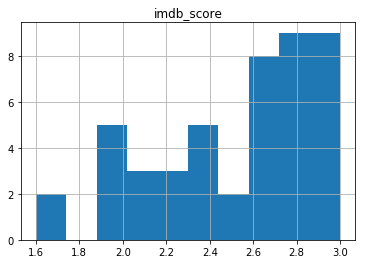

In [31]:
imdb_score_ol = return_outliers_k_std('imdb_score', 3)
print 'mean score', data[['imdb_score']].mean()
imdb_score_ol.sort_values('imdb_score').hist()

All outliers scores are below the mean. Maybe it was intentionally action to score down these movies.
For model predicting idbm score thesse values should be removed

## Overall correlation


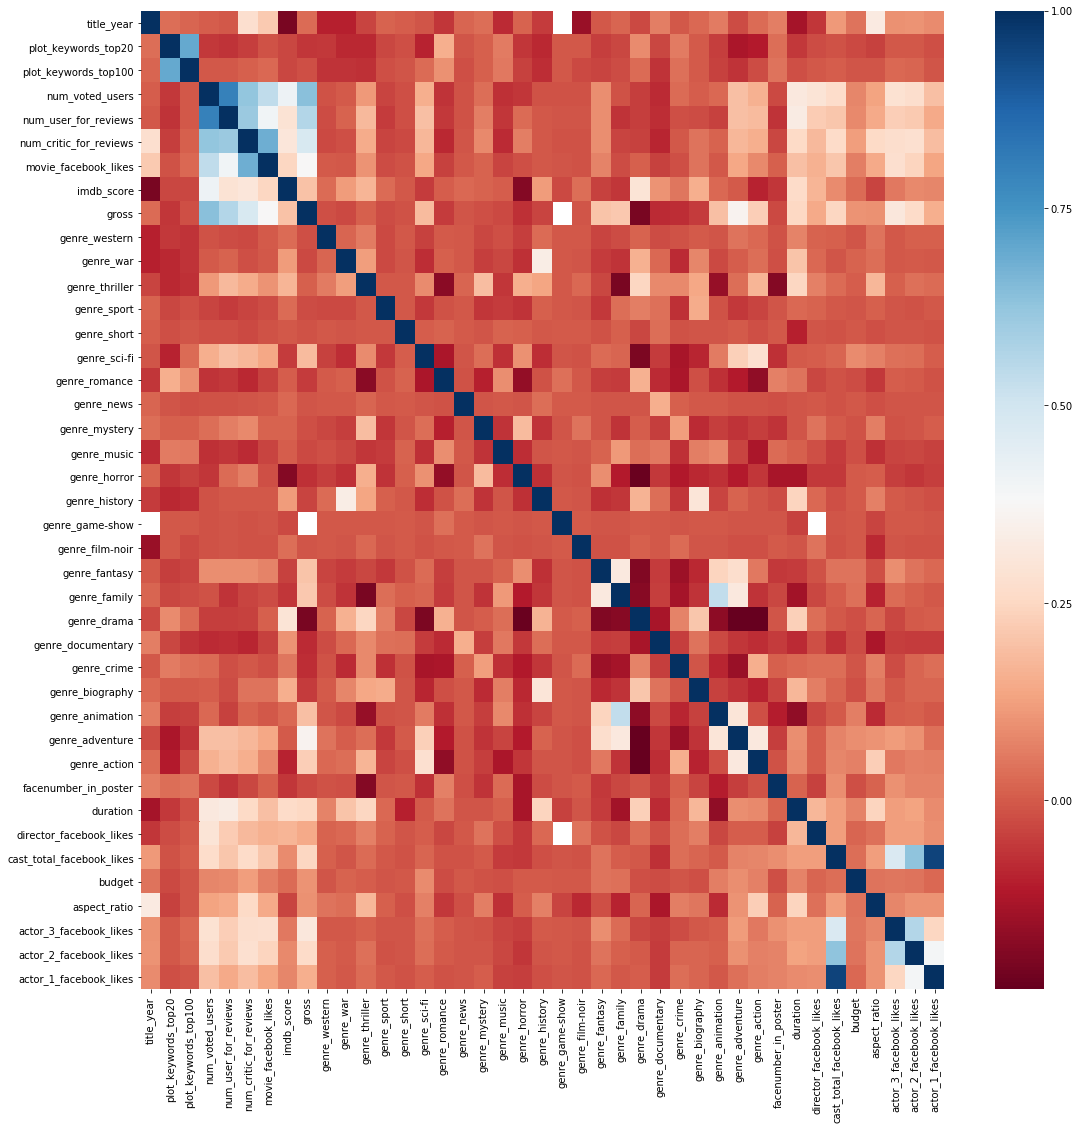

In [32]:
all_columns = sorted(data.columns, reverse=True)  # sort groups together similar features eg. genres_X, plot_Y
show_corr_heatmap(all_columns)

We can observe some correlation groups:
* genres features are not independent, 
* cast_total_facebook_likes are strong correlated with the main actor
* the gross of the movie is correlated with num_voted_users (measure of popularity?)
*

I tried to cluster genres using kmeans

In [33]:
from sklearn.cluster import KMeans

n_clu = 10

data_genres = pd.DataFrame(data, columns=new_genres_headers)
kmeans = KMeans(n_clusters=n_clu, random_state=0).fit(data_genres)
kmeans.labels_

array([9, 9, 9, ..., 2, 8, 7], dtype=int32)


## People connection
I would like to examine connections between top directors and top actors. 
I create director-actor graph to show the relation
Attention: The graph will be presented in separate browser tab

In [34]:
# Create edges dataframe
dir_th, act_th = 20, 5  # director make dir_th movies, actor plays act_th roles

df1 = data[['director_name', 'actor_1_name']].dropna().rename(columns={'actor_1_name': 'actor_name'})
df2 = data[['director_name', 'actor_2_name']].dropna().rename(columns={'actor_2_name': 'actor_name'})
data_edges = pd.concat([df1, df2])
most_common_dir = set(data_edges.groupby('director_name').filter(lambda d: len(d) > dir_th)['director_name'])  # filter directors
most_common_act = set(data_edges.groupby('actor_name').filter(lambda a: len(a) > act_th)['actor_name'])  # filter actors
data_edges.drop_duplicates(inplace=True)
data_edges = data_edges[data_edges.director_name.isin(most_common_dir) & data_edges.actor_name.isin(most_common_act)]


In [35]:
import plotly as py
from plotly.graph_objs import *
import random

import networkx as nx

G=nx.from_pandas_dataframe(data_edges, 'director_name', 'actor_name')

pos = nx.fruchterman_reingold_layout(G, iterations=100) 
#pos = nx.circular_layout(G) 
#pos = nx.random_layout(G) 
#pos = nx.shell_layout(G) 
#pos = nx.spring_layout(G) 
#pos = nx.spectral_layout(G) 

for node in G.nodes():
    G.node[node] = {'pos': pos[node]}
    
print nx.info(G)
print 'Density:', nx.density(G)

Name: 
Type: Graph
Number of nodes: 222
Number of edges: 351
Average degree:   3.1622
Density: 0.0143084260731


In [36]:
edge_trace = Scatter(
    x=[],
    y=[],
    line=Line(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_trace['x'] += [x0, x1, None]
    edge_trace['y'] += [y0, y1, None]

node_trace = Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=Marker(
        showscale=True,
        # colorscale options
        # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
        # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
        colorscale='YIGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = G.node[node]['pos']
    node_trace['x'].append(x)
    node_trace['y'].append(y)

for node, adjacencies in enumerate(G.adjacency_list()):
    node_trace['marker']['color'].append(len(adjacencies))
    person_name = G.nodes()[node]
    node_type = 'Director' if person_name in most_common_dir else 'Actor'
    node_info = node_type + ' ' + G.nodes()[node] + ': # of connections: '+str(len(adjacencies))
    node_trace['text'].append(node_info)
    
fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='<br>Top directors and actors network',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Director to actor connections",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))

py.offline.plot(fig, filename='director_actors.html')

Actors in the middle are more likely to work with many directors, while outer actors works with small number of directors



### Mising values

In [37]:
# show rows with the largest number of missing values
nan_count = data.isnull().sum(axis=1)
nan_count.nlargest(10)

279     14
4       13
2241    10
4945    10
2143     9
2342     9
2370     8
2459     8
4948     8
962      7
dtype: int64

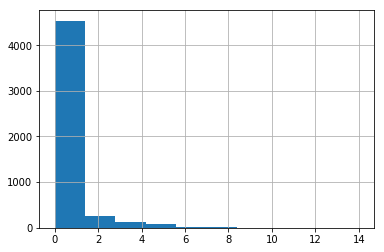

In [38]:
#show histogram of number of NaN in rows 
nan_count.hist()